In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_AR_v7 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-15 19:18:01.241613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:18:01.241932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:18:01.274377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:18:01.274717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:18:01.274922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_040'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_040
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

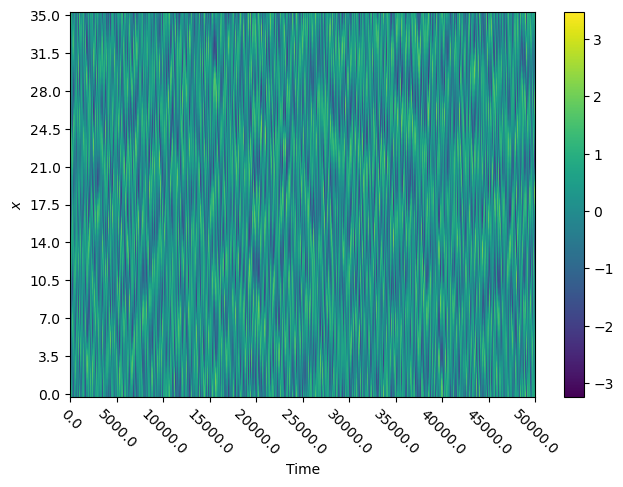

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([10, 30, 50])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_GRU.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-5],
        [5e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
35/35 [==============================] - ETA: 0s - loss: 0.0078 - mse: 9.3078e-04 - NMSE: 0.0084 - covmat_fro_loss: 6.4587e-04 - tot_time: 0h 0m 20.7s

Epoch 1: val_NMSE improved from inf to 0.00845, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [===============

Epoch 13/1000
35/35 [==============================] - ETA: 0s - loss: 0.0066 - mse: 7.8131e-04 - NMSE: 0.0070 - covmat_fro_loss: 5.9779e-04 - tot_time: 0h 1m 24.0s

Epoch 13: val_NMSE did not improve from 0.00783
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0066 - mse: 7.8131e-04 - NMSE: 0.0070 - covmat_fro_loss: 5.9819e-04 - val_loss: 0.0073 - val_mse: 8.7083e-04 - val_NMSE: 0.0078 - val_covmat_fro_loss: 0.0000e+00
Epoch 14/1000
35/35 [==============================] - ETA: 0s - loss: 0.0066 - mse: 7.7727e-04 - NMSE: 0.0070 - covmat_fro_loss: 5.9689e-04 - tot_time: 0h 1m 29.1s

Epoch 14: val_NMSE did not improve from 0.00783
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/s

Epoch 26/1000
35/35 [==============================] - ETA: 0s - loss: 0.0061 - mse: 7.1786e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.7666e-04 - tot_time: 0h 2m 32.2s

Epoch 26: val_NMSE improved from 0.00731 to 0.00731, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 152ms/step - loss: 0.0061 - mse: 7.1786e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.7684e-04 - val_loss: 0.0068 - val_mse: 8.1195e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00
Epoch 27/1000
35/35 [==============================] - ETA: 0s - loss: 0.0060 - mse: 7.1208e-04 - NMSE: 0.0064 - covmat_fro_loss: 5.7465e-04 - tot_time: 0h 2m 37.4s

Epoch 27: val_NMSE did not improve from 0.00731
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sa

Epoch 39/1000
35/35 [==============================] - ETA: 0s - loss: 0.0057 - mse: 6.6644e-04 - NMSE: 0.0060 - covmat_fro_loss: 5.5816e-04 - tot_time: 0h 3m 39.1s

Epoch 39: val_NMSE did not improve from 0.00702
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0057 - mse: 6.6644e-04 - NMSE: 0.0060 - covmat_fro_loss: 5.5790e-04 - val_loss: 0.0067 - val_mse: 7.9491e-04 - val_NMSE: 0.0072 - val_covmat_fro_loss: 0.0000e+00
Epoch 40/1000
35/35 [==============================] - ETA: 0s - loss: 0.0057 - mse: 6.6786e-04 - NMSE: 0.0060 - covmat_fro_loss: 5.5907e-04 - tot_time: 0h 3m 44.2s

Epoch 40: val_NMSE did not improve from 0.00702
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/s

35/35 [==============================] - ETA: 0s - loss: 0.0054 - mse: 6.3076e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.4405e-04 - tot_time: 0h 4m 45.8s

Epoch 52: val_NMSE improved from 0.00683 to 0.00682, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 151ms/step - loss: 0.0054 - mse: 6.3076e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.4382e-04 - val_loss: 0.0064 - val_mse: 7.5799e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00
Epoch 53/1000
35/35 [==============================] - ETA: 0s - loss: 0.0054 - mse: 6.2579e-04 - NMSE: 0.0056 - covmat_fro_loss: 5.4259e-04 - tot_time: 0h 4m 51.1s

Epoch 53: val_NMSE improved from 0.00682 to 0.00678, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0052 - mse: 6.0006e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.3253e-04 - val_loss: 0.0062 - val_mse: 7.3035e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00
Epoch 65/1000
35/35 [==============================] - ETA: 0s - loss: 0.0052 - mse: 5.9941e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.3176e-04 - tot_time: 0h 5m 54.0s

Epoch 65: val_NMSE did not improve from 0.00657
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0052 - mse: 5.9941e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.3163e-04 - val_loss: 0.0062 - val_mse: 7.3134e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00
Epoch 66/1000
35/35 [=================

35/35 [==============================] - ETA: 0s - loss: 0.0050 - mse: 5.7310e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.2089e-04 - tot_time: 0h 6m 56.8s

Epoch 77: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0050 - mse: 5.7310e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.2069e-04 - val_loss: 0.0060 - val_mse: 7.0487e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00
Epoch 78/1000
35/35 [==============================] - ETA: 0s - loss: 0.0049 - mse: 5.7083e-04 - NMSE: 0.0051 - covmat_fro_loss: 5.2018e-04 - tot_time: 0h 7m 2.0s

Epoch 78: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0

Epoch 90/1000
35/35 [==============================] - ETA: 0s - loss: 0.0048 - mse: 5.4991e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.1173e-04 - tot_time: 0h 8m 5.1s

Epoch 90: val_NMSE did not improve from 0.00618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0048 - mse: 5.4991e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.1131e-04 - val_loss: 0.0059 - val_mse: 6.9130e-04 - val_NMSE: 0.0062 - val_covmat_fro_loss: 0.0000e+00
Epoch 91/1000
35/35 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.4641e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.1006e-04 - tot_time: 0h 8m 10.5s

Epoch 91: val_NMSE improved from 0.00618 to 0.00616, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sav

35/35 [==============================] - ETA: 0s - loss: 0.0046 - mse: 5.2695e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.0149e-04 - tot_time: 0h 9m 14.0s

Epoch 103: val_NMSE improved from 0.00602 to 0.00601, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 152ms/step - loss: 0.0046 - mse: 5.2695e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.0193e-04 - val_loss: 0.0057 - val_mse: 6.6724e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 104/1000
35/35 [==============================] - ETA: 0s - loss: 0.0046 - mse: 5.2653e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.0132e-04 - tot_time: 0h 9m 19.3s

Epoch 104: val_NMSE improved from 0.00601 to 0.00597, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 116/1000
35/35 [==============================] - ETA: 0s - loss: 0.0044 - mse: 5.0913e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.9337e-04 - tot_time: 0h 10m 21.8s

Epoch 116: val_NMSE did not improve from 0.00579
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0044 - mse: 5.0913e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.9406e-04 - val_loss: 0.0056 - val_mse: 6.5828e-04 - val_NMSE: 0.0059 - val_covmat_fro_loss: 0.0000e+00
Epoch 117/1000
35/35 [==============================] - ETA: 0s - loss: 0.0044 - mse: 5.0487e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.9193e-04 - tot_time: 0h 10m 26.9s

Epoch 117: val_NMSE did not improve from 0.00579
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 130/1000
35/35 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.8742e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.8410e-04 - tot_time: 0h 11m 34.6s

Epoch 130: val_NMSE did not improve from 0.00571
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 154ms/step - loss: 0.0043 - mse: 4.8742e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.8338e-04 - val_loss: 0.0055 - val_mse: 6.3832e-04 - val_NMSE: 0.0057 - val_covmat_fro_loss: 0.0000e+00
Epoch 131/1000
35/35 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.8550e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.8326e-04 - tot_time: 0h 11m 39.8s

Epoch 131: val_NMSE did not improve from 0.00571
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 143/1000
35/35 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.7081e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.7612e-04 - tot_time: 0h 12m 42.2s

Epoch 143: val_NMSE did not improve from 0.00558
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0041 - mse: 4.7081e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.7579e-04 - val_loss: 0.0053 - val_mse: 6.2391e-04 - val_NMSE: 0.0056 - val_covmat_fro_loss: 0.0000e+00
Epoch 144/1000
35/35 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.7177e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.7658e-04 - tot_time: 0h 12m 47.3s

Epoch 144: val_NMSE did not improve from 0.00558
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 156/1000
35/35 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.5641e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6862e-04 - tot_time: 0h 13m 50.0s

Epoch 156: val_NMSE improved from 0.00544 to 0.00540, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0040 - mse: 4.5641e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6867e-04 - val_loss: 0.0052 - val_mse: 6.0029e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00
Epoch 157/1000
35/35 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.5258e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6746e-04 - tot_time: 0h 13m 55.3s

Epoch 157: val_NMSE did not improve from 0.00540
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 169/1000
35/35 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.4377e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.6279e-04 - tot_time: 0h 14m 57.9s

Epoch 169: val_NMSE did not improve from 0.00534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0039 - mse: 4.4377e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.6287e-04 - val_loss: 0.0052 - val_mse: 6.0089e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00
Epoch 170/1000
35/35 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.4007e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.6140e-04 - tot_time: 0h 15m 3.1s

Epoch 170: val_NMSE improved from 0.00534 to 0.00534, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

35/35 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.2876e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5540e-04 - tot_time: 0h 16m 5.1s

Epoch 182: val_NMSE improved from 0.00524 to 0.00523, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0038 - mse: 4.2876e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5511e-04 - val_loss: 0.0050 - val_mse: 5.8070e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00
Epoch 183/1000
35/35 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.2621e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.5455e-04 - tot_time: 0h 16m 10.4s

Epoch 183: val_NMSE did not improve from 0.00523
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

35/35 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.1742e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4987e-04 - tot_time: 0h 17m 8.0s

Epoch 194: val_NMSE did not improve from 0.00510
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0037 - mse: 4.1742e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.5112e-04 - val_loss: 0.0050 - val_mse: 5.7609e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00
Epoch 195/1000
35/35 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.1679e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4978e-04 - tot_time: 0h 17m 13.2s

Epoch 195: val_NMSE did not improve from 0.00510
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss

Epoch 207/1000
35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.0683e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.4455e-04 - tot_time: 0h 18m 15.5s

Epoch 207: val_NMSE improved from 0.00502 to 0.00502, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0036 - mse: 4.0683e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.4425e-04 - val_loss: 0.0048 - val_mse: 5.5730e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00
Epoch 208/1000
35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.0510e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.4414e-04 - tot_time: 0h 18m 20.6s

Epoch 208: val_NMSE did not improve from 0.00502
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.9376e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3785e-04 - tot_time: 0h 19m 22.7s

Epoch 220: val_NMSE did not improve from 0.00492
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0035 - mse: 3.9376e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3801e-04 - val_loss: 0.0048 - val_mse: 5.5596e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00
Epoch 221/1000
35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.9479e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3886e-04 - tot_time: 0h 19m 27.8s

Epoch 221: val_NMSE did not improve from 0.00492
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - los

35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.8391e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3269e-04 - tot_time: 0h 20m 30.6s

Epoch 233: val_NMSE did not improve from 0.00488
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0035 - mse: 3.8391e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3292e-04 - val_loss: 0.0047 - val_mse: 5.4344e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00
Epoch 234/1000
35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.8386e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3293e-04 - tot_time: 0h 20m 35.8s

Epoch 234: val_NMSE improved from 0.00488 to 0.00484, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 246/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.7877e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2983e-04 - tot_time: 0h 21m 38.2s

Epoch 246: val_NMSE did not improve from 0.00476
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0034 - mse: 3.7877e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2988e-04 - val_loss: 0.0046 - val_mse: 5.3526e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00
Epoch 247/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.7578e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2857e-04 - tot_time: 0h 21m 43.4s

Epoch 247: val_NMSE did not improve from 0.00476
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6693e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.2373e-04 - tot_time: 0h 22m 45.4s

Epoch 259: val_NMSE did not improve from 0.00471
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0033 - mse: 3.6693e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.2385e-04 - val_loss: 0.0046 - val_mse: 5.2548e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00
Epoch 260/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6561e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.2325e-04 - tot_time: 0h 22m 50.4s

Epoch 260: val_NMSE improved from 0.00471 to 0.00471, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 272/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.5882e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1918e-04 - tot_time: 0h 23m 52.9s

Epoch 272: val_NMSE did not improve from 0.00463
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0033 - mse: 3.5882e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1928e-04 - val_loss: 0.0045 - val_mse: 5.1758e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00
Epoch 273/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5721e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1774e-04 - tot_time: 0h 23m 58.0s

Epoch 273: val_NMSE did not improve from 0.00463
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5185e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1544e-04 - tot_time: 0h 24m 59.8s

Epoch 285: val_NMSE did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0032 - mse: 3.5185e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1579e-04 - val_loss: 0.0045 - val_mse: 5.1154e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00
Epoch 286/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5114e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1477e-04 - tot_time: 0h 25m 5.0s

Epoch 286: val_NMSE improved from 0.00456 to 0.00451, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 153ms/step - loss: 0.0031 - mse: 3.4353e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.1020e-04 - val_loss: 0.0044 - val_mse: 5.0101e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00
Epoch 299/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4119e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0872e-04 - tot_time: 0h 26m 12.7s

Epoch 299: val_NMSE did not improve from 0.00447
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0031 - mse: 3.4119e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0867e-04 - val_loss: 0.0044 - val_mse: 4.9973e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00
Epoch 300/1000
35/35 [=============

Epoch 312/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.3434e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0545e-04 - tot_time: 0h 27m 18.7s

Epoch 312: val_NMSE did not improve from 0.00441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0031 - mse: 3.3434e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0511e-04 - val_loss: 0.0043 - val_mse: 4.9009e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00
Epoch 313/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.3460e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0519e-04 - tot_time: 0h 27m 23.8s

Epoch 313: val_NMSE did not improve from 0.00441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 326/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.3084e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0291e-04 - tot_time: 0h 28m 31.4s

Epoch 326: val_NMSE improved from 0.00438 to 0.00438, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0030 - mse: 3.3084e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0297e-04 - val_loss: 0.0043 - val_mse: 4.8669e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00
Epoch 327/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2967e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0289e-04 - tot_time: 0h 28m 36.7s

Epoch 327: val_NMSE did not improve from 0.00438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 339/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2162e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9734e-04 - tot_time: 0h 29m 38.2s

Epoch 339: val_NMSE did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0030 - mse: 3.2162e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9817e-04 - val_loss: 0.0042 - val_mse: 4.7980e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00
Epoch 340/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2270e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9817e-04 - tot_time: 0h 29m 43.3s

Epoch 340: val_NMSE did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 353/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1604e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9431e-04 - tot_time: 0h 30m 50.2s

Epoch 353: val_NMSE did not improve from 0.00424
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0029 - mse: 3.1604e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9390e-04 - val_loss: 0.0041 - val_mse: 4.7176e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00
Epoch 354/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1556e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9428e-04 - tot_time: 0h 30m 55.3s

Epoch 354: val_NMSE did not improve from 0.00424
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0887e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8999e-04 - tot_time: 0h 31m 53.1s

Epoch 366: val_NMSE improved from 0.00418 to 0.00417, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0029 - mse: 3.0887e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9040e-04 - val_loss: 0.0041 - val_mse: 4.6297e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00
Epoch 367/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0726e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8917e-04 - tot_time: 0h 31m 58.1s

Epoch 367: val_NMSE improved from 0.00417 to 0.00415, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0127e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8573e-04 - tot_time: 0h 32m 56.4s

Epoch 379: val_NMSE did not improve from 0.00409
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 137ms/step - loss: 0.0028 - mse: 3.0127e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8561e-04 - val_loss: 0.0041 - val_mse: 4.6154e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00
Epoch 380/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0302e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8696e-04 - tot_time: 0h 33m 0.9s

Epoch 380: val_NMSE improved from 0.00409 to 0.00406, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 393/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9760e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8333e-04 - tot_time: 0h 34m 0.3s

Epoch 393: val_NMSE did not improve from 0.00406
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 132ms/step - loss: 0.0028 - mse: 2.9760e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8355e-04 - val_loss: 0.0040 - val_mse: 4.5683e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00
Epoch 394/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9698e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8304e-04 - tot_time: 0h 34m 4.9s

Epoch 394: val_NMSE did not improve from 0.00406
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 133

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0027 - mse: 2.9019e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7857e-04 - val_loss: 0.0039 - val_mse: 4.4352e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00
Epoch 407/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.9203e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7981e-04 - tot_time: 0h 35m 6.3s

Epoch 407: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 132ms/step - loss: 0.0027 - mse: 2.9203e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7992e-04 - val_loss: 0.0040 - val_mse: 4.4978e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00
Epoch 408/1000
35/35 [==============

Epoch 420/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8501e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7517e-04 - tot_time: 0h 36m 7.7s

Epoch 420: val_NMSE did not improve from 0.00394
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0027 - mse: 2.8501e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7600e-04 - val_loss: 0.0039 - val_mse: 4.4535e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00
Epoch 421/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8736e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7687e-04 - tot_time: 0h 36m 12.6s

Epoch 421: val_NMSE did not improve from 0.00394
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 14

Epoch 434/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.8106e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7261e-04 - tot_time: 0h 37m 14.9s

Epoch 434: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 137ms/step - loss: 0.0026 - mse: 2.8106e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7251e-04 - val_loss: 0.0039 - val_mse: 4.3710e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00
Epoch 435/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7948e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7227e-04 - tot_time: 0h 37m 19.8s

Epoch 435: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7755e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7054e-04 - tot_time: 0h 38m 17.7s

Epoch 447: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 138ms/step - loss: 0.0026 - mse: 2.7755e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7064e-04 - val_loss: 0.0039 - val_mse: 4.3790e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00
Epoch 448/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7841e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7120e-04 - tot_time: 0h 38m 22.4s

Epoch 448: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0026 - mse: 2.7284e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6741e-04 - val_loss: 0.0038 - val_mse: 4.2308e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00
Epoch 461/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7313e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6779e-04 - tot_time: 0h 39m 25.9s

Epoch 461: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0026 - mse: 2.7313e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6759e-04 - val_loss: 0.0038 - val_mse: 4.2641e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00
Epoch 462/1000
35/35 [=============

35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6893e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6476e-04 - tot_time: 0h 40m 28.3s

Epoch 474: val_NMSE did not improve from 0.00377
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - loss: 0.0025 - mse: 2.6893e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6457e-04 - val_loss: 0.0038 - val_mse: 4.2143e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00
Epoch 475/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6785e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6414e-04 - tot_time: 0h 40m 33.1s

Epoch 475: val_NMSE did not improve from 0.00377
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 137ms/step - los

Epoch 488/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6134e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5978e-04 - tot_time: 0h 41m 35.6s

Epoch 488: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 138ms/step - loss: 0.0025 - mse: 2.6134e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5985e-04 - val_loss: 0.0037 - val_mse: 4.2069e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00
Epoch 489/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6164e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6016e-04 - tot_time: 0h 41m 40.4s

Epoch 489: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 502/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5772e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5752e-04 - tot_time: 0h 42m 42.3s

Epoch 502: val_NMSE did not improve from 0.00371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0025 - mse: 2.5772e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5757e-04 - val_loss: 0.0037 - val_mse: 4.1559e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 503/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5890e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5823e-04 - tot_time: 0h 42m 47.1s

Epoch 503: val_NMSE improved from 0.00371 to 0.00371, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5550e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5645e-04 - tot_time: 0h 43m 44.7s

Epoch 515: val_NMSE did not improve from 0.00367
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 131ms/step - loss: 0.0024 - mse: 2.5550e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5671e-04 - val_loss: 0.0037 - val_mse: 4.0955e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 516/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5465e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5533e-04 - tot_time: 0h 43m 49.6s

Epoch 516: val_NMSE did not improve from 0.00367
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 138ms/step - los

Epoch 529/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5206e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5352e-04 - tot_time: 0h 44m 52.0s

Epoch 529: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 138ms/step - loss: 0.0024 - mse: 2.5206e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5348e-04 - val_loss: 0.0036 - val_mse: 4.0507e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 530/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5161e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.5355e-04 - tot_time: 0h 44m 56.8s

Epoch 530: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4941e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5219e-04 - tot_time: 0h 45m 53.9s

Epoch 542: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 136ms/step - loss: 0.0024 - mse: 2.4941e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5195e-04 - val_loss: 0.0036 - val_mse: 4.0008e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 543/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4857e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5135e-04 - tot_time: 0h 45m 58.4s

Epoch 543: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 130ms/step - los

Epoch 556/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4552e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4951e-04 - tot_time: 0h 46m 60.0s

Epoch 556: val_NMSE did not improve from 0.00357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 136ms/step - loss: 0.0024 - mse: 2.4552e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4966e-04 - val_loss: 0.0036 - val_mse: 3.9949e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 557/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4263e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4725e-04 - tot_time: 0h 47m 4.8s

Epoch 557: val_NMSE did not improve from 0.00357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 13

Epoch 570/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4113e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4590e-04 - tot_time: 0h 48m 7.0s

Epoch 570: val_NMSE did not improve from 0.00349
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 135ms/step - loss: 0.0023 - mse: 2.4113e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4579e-04 - val_loss: 0.0036 - val_mse: 3.9751e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 571/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.4059e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4563e-04 - tot_time: 0h 48m 11.7s

Epoch 571: val_NMSE did not improve from 0.00349
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 13

Epoch 584/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3839e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4442e-04 - tot_time: 0h 49m 13.6s

Epoch 584: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 135ms/step - loss: 0.0023 - mse: 2.3839e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4447e-04 - val_loss: 0.0035 - val_mse: 3.8810e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 585/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3713e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4364e-04 - tot_time: 0h 49m 18.3s

Epoch 585: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 598/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3343e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4066e-04 - tot_time: 0h 50m 20.5s

Epoch 598: val_NMSE did not improve from 0.00346
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - loss: 0.0023 - mse: 2.3343e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4061e-04 - val_loss: 0.0035 - val_mse: 3.8689e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 599/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3480e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4165e-04 - tot_time: 0h 50m 25.3s

Epoch 599: val_NMSE did not improve from 0.00346
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3161e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3931e-04 - tot_time: 0h 51m 22.7s

Epoch 611: val_NMSE improved from 0.00343 to 0.00343, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0023 - mse: 2.3161e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3992e-04 - val_loss: 0.0034 - val_mse: 3.8061e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 612/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3219e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3986e-04 - tot_time: 0h 51m 27.6s

Epoch 612: val_NMSE did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2887e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3790e-04 - tot_time: 0h 52m 25.7s

Epoch 624: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0022 - mse: 2.2887e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3767e-04 - val_loss: 0.0034 - val_mse: 3.7803e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 625/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2815e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3699e-04 - tot_time: 0h 52m 30.4s

Epoch 625: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 136ms/step - los

Epoch 638/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2568e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3513e-04 - tot_time: 0h 53m 33.3s

Epoch 638: val_NMSE did not improve from 0.00333
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 135ms/step - loss: 0.0022 - mse: 2.2568e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3512e-04 - val_loss: 0.0034 - val_mse: 3.7831e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 639/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2529e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3464e-04 - tot_time: 0h 53m 38.2s

Epoch 639: val_NMSE did not improve from 0.00333
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 652/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2405e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3361e-04 - tot_time: 0h 54m 39.9s

Epoch 652: val_NMSE did not improve from 0.00333
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 135ms/step - loss: 0.0022 - mse: 2.2405e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3381e-04 - val_loss: 0.0034 - val_mse: 3.8065e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 653/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.2237e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3281e-04 - tot_time: 0h 54m 44.6s

Epoch 653: val_NMSE improved from 0.00333 to 0.00330, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 666/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1824e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2974e-04 - tot_time: 0h 55m 46.9s

Epoch 666: val_NMSE did not improve from 0.00328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 132ms/step - loss: 0.0021 - mse: 2.1824e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.2998e-04 - val_loss: 0.0033 - val_mse: 3.6572e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 667/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.1883e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3022e-04 - tot_time: 0h 55m 51.7s

Epoch 667: val_NMSE did not improve from 0.00328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 680/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1600e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2828e-04 - tot_time: 0h 56m 53.2s

Epoch 680: val_NMSE did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 135ms/step - loss: 0.0021 - mse: 2.1600e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2869e-04 - val_loss: 0.0033 - val_mse: 3.6636e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 681/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1604e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2815e-04 - tot_time: 0h 56m 57.8s

Epoch 681: val_NMSE did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 694/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1309e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2601e-04 - tot_time: 0h 57m 59.3s

Epoch 694: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 137ms/step - loss: 0.0021 - mse: 2.1309e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2595e-04 - val_loss: 0.0033 - val_mse: 3.6649e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 695/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1384e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2643e-04 - tot_time: 0h 58m 4.1s

Epoch 695: val_NMSE improved from 0.00324 to 0.00323, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 708/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1268e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2539e-04 - tot_time: 0h 59m 5.6s

Epoch 708: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 133ms/step - loss: 0.0021 - mse: 2.1268e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2554e-04 - val_loss: 0.0033 - val_mse: 3.6132e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 709/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1056e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2386e-04 - tot_time: 0h 59m 10.6s

Epoch 709: val_NMSE improved from 0.00321 to 0.00320, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 722/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.0837e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2218e-04 - tot_time: 1h 0m 13.3s

Epoch 722: val_NMSE did not improve from 0.00319
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 137ms/step - loss: 0.0021 - mse: 2.0837e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2198e-04 - val_loss: 0.0033 - val_mse: 3.5984e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 723/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.1046e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.2389e-04 - tot_time: 1h 0m 18.0s

Epoch 723: val_NMSE did not improve from 0.00319
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134

Epoch 736/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0501e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1954e-04 - tot_time: 1h 1m 19.8s

Epoch 736: val_NMSE improved from 0.00319 to 0.00318, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0020 - mse: 2.0501e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1946e-04 - val_loss: 0.0032 - val_mse: 3.5344e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 737/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0527e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1978e-04 - tot_time: 1h 1m 24.6s

Epoch 737: val_NMSE did not improve from 0.00318
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/K

35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0343e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1834e-04 - tot_time: 1h 2m 21.8s

Epoch 749: val_NMSE improved from 0.00315 to 0.00314, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0020 - mse: 2.0343e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1809e-04 - val_loss: 0.0032 - val_mse: 3.4851e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 750/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0346e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1856e-04 - tot_time: 1h 2m 26.7s

Epoch 750: val_NMSE did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 137ms/step - loss: 0.0020 - mse: 2.0100e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1639e-04 - val_loss: 0.0032 - val_mse: 3.5038e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 763/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0081e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1628e-04 - tot_time: 1h 3m 28.6s

Epoch 763: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 136ms/step - loss: 0.0020 - mse: 2.0081e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1620e-04 - val_loss: 0.0032 - val_mse: 3.4997e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 764/1000
35/35 [==============

Epoch 776/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0050e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1579e-04 - tot_time: 1h 4m 30.7s

Epoch 776: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - loss: 0.0020 - mse: 2.0050e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1609e-04 - val_loss: 0.0032 - val_mse: 3.4789e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 777/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.0095e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1666e-04 - tot_time: 1h 4m 35.6s

Epoch 777: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140

Epoch 790/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9716e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1358e-04 - tot_time: 1h 5m 37.3s

Epoch 790: val_NMSE improved from 0.00308 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - loss: 0.0020 - mse: 1.9716e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1399e-04 - val_loss: 0.0031 - val_mse: 3.3899e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 791/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9700e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1345e-04 - tot_time: 1h 5m 42.0s

Epoch 791: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/K

Epoch 804/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9495e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1191e-04 - tot_time: 1h 6m 42.0s

Epoch 804: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - loss: 0.0020 - mse: 1.9495e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1164e-04 - val_loss: 0.0032 - val_mse: 3.4654e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 805/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.9534e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.1226e-04 - tot_time: 1h 6m 46.7s

Epoch 805: val_NMSE improved from 0.00305 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/K

Epoch 818/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9254e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0993e-04 - tot_time: 1h 7m 47.5s

Epoch 818: val_NMSE improved from 0.00305 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0019 - mse: 1.9254e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.1002e-04 - val_loss: 0.0031 - val_mse: 3.3843e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 819/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9237e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.1001e-04 - tot_time: 1h 7m 52.7s

Epoch 819: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/K

35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9293e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.1038e-04 - tot_time: 1h 8m 49.2s

Epoch 831: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 136ms/step - loss: 0.0019 - mse: 1.9293e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.1085e-04 - val_loss: 0.0031 - val_mse: 3.4048e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 832/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.9138e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0894e-04 - tot_time: 1h 8m 53.9s

Epoch 832: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 135ms/step - loss:

Epoch 845/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8823e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0673e-04 - tot_time: 1h 9m 54.5s

Epoch 845: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 129ms/step - loss: 0.0019 - mse: 1.8823e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0667e-04 - val_loss: 0.0031 - val_mse: 3.3536e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 846/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8872e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0697e-04 - tot_time: 1h 9m 59.1s

Epoch 846: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134

Epoch 859/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8715e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0527e-04 - tot_time: 1h 11m 0.1s

Epoch 859: val_NMSE improved from 0.00299 to 0.00297, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 135ms/step - loss: 0.0019 - mse: 1.8715e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0510e-04 - val_loss: 0.0030 - val_mse: 3.3024e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 860/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8828e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0632e-04 - tot_time: 1h 11m 4.9s

Epoch 860: val_NMSE improved from 0.00297 to 0.00297, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved

Epoch 872/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8638e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0480e-04 - tot_time: 1h 12m 1.7s

Epoch 872: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 133ms/step - loss: 0.0019 - mse: 1.8638e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0470e-04 - val_loss: 0.0030 - val_mse: 3.3063e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 873/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8545e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0407e-04 - tot_time: 1h 12m 6.4s

Epoch 873: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 133

Epoch 886/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8356e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0246e-04 - tot_time: 1h 13m 7.0s

Epoch 886: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 131ms/step - loss: 0.0019 - mse: 1.8356e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0256e-04 - val_loss: 0.0030 - val_mse: 3.2682e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 887/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8516e-04 - NMSE: 0.0017 - covmat_fro_loss: 3.0370e-04 - tot_time: 1h 13m 11.6s

Epoch 887: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 13

Epoch 900/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8170e-04 - NMSE: 0.0016 - covmat_fro_loss: 3.0089e-04 - tot_time: 1h 14m 12.8s

Epoch 900: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 136ms/step - loss: 0.0019 - mse: 1.8170e-04 - NMSE: 0.0016 - covmat_fro_loss: 3.0095e-04 - val_loss: 0.0030 - val_mse: 3.2933e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 901/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8310e-04 - NMSE: 0.0016 - covmat_fro_loss: 3.0236e-04 - tot_time: 1h 14m 17.4s

Epoch 901: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 914/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.8107e-04 - NMSE: 0.0016 - covmat_fro_loss: 3.0088e-04 - tot_time: 1h 15m 18.3s

Epoch 914: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - loss: 0.0019 - mse: 1.8107e-04 - NMSE: 0.0016 - covmat_fro_loss: 3.0112e-04 - val_loss: 0.0030 - val_mse: 3.2333e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 915/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8034e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9968e-04 - tot_time: 1h 15m 23.0s

Epoch 915: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 928/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7777e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9752e-04 - tot_time: 1h 16m 24.8s

Epoch 928: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0018 - mse: 1.7777e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9754e-04 - val_loss: 0.0030 - val_mse: 3.2083e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 929/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.8033e-04 - NMSE: 0.0016 - covmat_fro_loss: 3.0002e-04 - tot_time: 1h 16m 29.4s

Epoch 929: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 942/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7695e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9714e-04 - tot_time: 1h 17m 30.7s

Epoch 942: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 130ms/step - loss: 0.0018 - mse: 1.7695e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9732e-04 - val_loss: 0.0029 - val_mse: 3.1872e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 943/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7658e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9676e-04 - tot_time: 1h 17m 35.4s

Epoch 943: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 956/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7353e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9459e-04 - tot_time: 1h 18m 36.3s

Epoch 956: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 132ms/step - loss: 0.0018 - mse: 1.7353e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9466e-04 - val_loss: 0.0029 - val_mse: 3.1748e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 957/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7608e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9627e-04 - tot_time: 1h 18m 40.9s

Epoch 957: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 970/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7202e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9307e-04 - tot_time: 1h 19m 41.3s

Epoch 970: val_NMSE did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 137ms/step - loss: 0.0018 - mse: 1.7202e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9315e-04 - val_loss: 0.0029 - val_mse: 3.1459e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 971/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7350e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9443e-04 - tot_time: 1h 19m 46.0s

Epoch 971: val_NMSE did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 984/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7110e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9226e-04 - tot_time: 1h 20m 46.3s

Epoch 984: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 130ms/step - loss: 0.0018 - mse: 1.7110e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9190e-04 - val_loss: 0.0029 - val_mse: 3.1737e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 985/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7083e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9219e-04 - tot_time: 1h 20m 50.9s

Epoch 985: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

Epoch 998/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.7152e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9255e-04 - tot_time: 1h 21m 51.2s

Epoch 998: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 134ms/step - loss: 0.0018 - mse: 1.7152e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9247e-04 - val_loss: 0.0029 - val_mse: 3.1073e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 999/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6979e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.9089e-04 - tot_time: 1h 21m 55.9s

Epoch 999: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 1

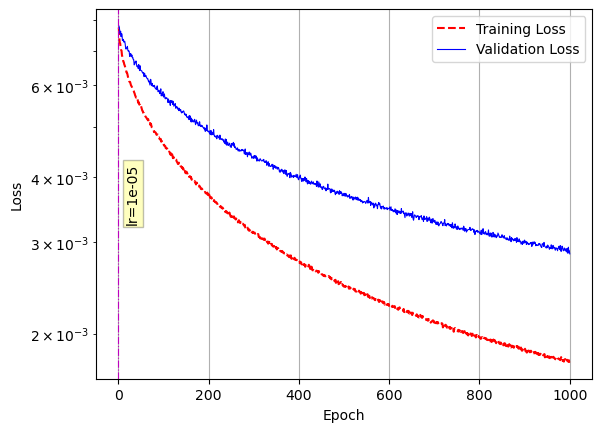



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
29/29 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0013 - NMSE: 0.0113 - covmat_fro_loss: 0.0014 - tot_time: 0h 0m 55.5s

Epoch 1: val_NMSE improved from inf to 0.01199, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [=======================

Epoch 13/1000
29/29 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - tot_time: 0h 2m 4.7s

Epoch 13: val_NMSE did not improve from 0.01137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0093 - covmat_fro_loss: 0.0013 - val_loss: 0.0080 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00
Epoch 14/1000
29/29 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0013 - tot_time: 0h 2m 10.6s

Epoch 14: val_NMSE improved from 0.01137 to 0.01133, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/c

Epoch 27/1000
29/29 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.7050e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - tot_time: 0h 3m 25.1s

Epoch 27: val_NMSE did not improve from 0.01109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0062 - mse: 9.7050e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0012 - val_loss: 0.0082 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00
Epoch 28/1000
29/29 [==============================] - ETA: 0s - loss: 0.0062 - mse: 9.5923e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0012 - tot_time: 0h 3m 30.7s

Epoch 28: val_NMSE did not improve from 0.01109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.00

Epoch 41/1000
29/29 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1719e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - tot_time: 0h 4m 44.6s

Epoch 41: val_NMSE did not improve from 0.01091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 190ms/step - loss: 0.0059 - mse: 9.1719e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00
Epoch 42/1000
29/29 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.1733e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - tot_time: 0h 4m 50.4s

Epoch 42: val_NMSE did not improve from 0.01091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.00

Epoch 55/1000
29/29 [==============================] - ETA: 0s - loss: 0.0057 - mse: 8.8735e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - tot_time: 0h 6m 4.6s

Epoch 55: val_NMSE did not improve from 0.01084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192ms/step - loss: 0.0057 - mse: 8.8735e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00
Epoch 56/1000
29/29 [==============================] - ETA: 0s - loss: 0.0057 - mse: 8.7895e-04 - NMSE: 0.0079 - covmat_fro_loss: 0.0012 - tot_time: 0h 6m 10.3s

Epoch 56: val_NMSE did not improve from 0.01084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.005

29/29 [==============================] - ETA: 0s - loss: 0.0055 - mse: 8.4946e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0012 - tot_time: 0h 7m 23.5s

Epoch 69: val_NMSE improved from 0.01083 to 0.01075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms/step - loss: 0.0055 - mse: 8.4946e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0012 - val_loss: 0.0075 - val_mse: 0.0012 - val_NMSE: 0.0107 - val_covmat_fro_loss: 0.0000e+00
Epoch 70/1000
29/29 [==============================] - ETA: 0s - loss: 0.0055 - mse: 8.4462e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0012 - tot_time: 0h 7m 29.1s

Epoch 70: val_NMSE improved from 0.01075 to 0.01075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoin

Epoch 83/1000
29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.2678e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - tot_time: 0h 8m 43.2s

Epoch 83: val_NMSE did not improve from 0.01064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms/step - loss: 0.0054 - mse: 8.2678e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - val_loss: 0.0075 - val_mse: 0.0012 - val_NMSE: 0.0108 - val_covmat_fro_loss: 0.0000e+00
Epoch 84/1000
29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.2399e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - tot_time: 0h 8m 48.9s

Epoch 84: val_NMSE did not improve from 0.01064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.00

29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.2228e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - tot_time: 0h 10m 2.5s

Epoch 97: val_NMSE did not improve from 0.01064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0054 - mse: 8.2228e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - val_loss: 0.0075 - val_mse: 0.0012 - val_NMSE: 0.0107 - val_covmat_fro_loss: 0.0000e+00
Epoch 98/1000
29/29 [==============================] - ETA: 0s - loss: 0.0053 - mse: 8.1143e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - tot_time: 0h 10m 8.2s

Epoch 98: val_NMSE improved from 0.01064 to 0.01053, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/ch

Epoch 111/1000
29/29 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.7744e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - tot_time: 0h 11m 23.3s

Epoch 111: val_NMSE did not improve from 0.01043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0051 - mse: 7.7744e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0011 - val_loss: 0.0074 - val_mse: 0.0012 - val_NMSE: 0.0106 - val_covmat_fro_loss: 0.0000e+00
Epoch 112/1000
29/29 [==============================] - ETA: 0s - loss: 0.0052 - mse: 7.8881e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0011 - tot_time: 0h 11m 29.0s

Epoch 112: val_NMSE did not improve from 0.01043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss

Epoch 125/1000
29/29 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.6746e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - tot_time: 0h 12m 43.0s

Epoch 125: val_NMSE did not improve from 0.01030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 204ms/step - loss: 0.0051 - mse: 7.6746e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - val_loss: 0.0073 - val_mse: 0.0012 - val_NMSE: 0.0105 - val_covmat_fro_loss: 0.0000e+00
Epoch 126/1000
29/29 [==============================] - ETA: 0s - loss: 0.0050 - mse: 7.6426e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - tot_time: 0h 12m 48.8s

Epoch 126: val_NMSE did not improve from 0.01030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss

29/29 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.4550e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - tot_time: 0h 14m 1.2s

Epoch 139: val_NMSE did not improve from 0.01030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 191ms/step - loss: 0.0049 - mse: 7.4550e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - val_loss: 0.0073 - val_mse: 0.0012 - val_NMSE: 0.0104 - val_covmat_fro_loss: 0.0000e+00
Epoch 140/1000
29/29 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.4151e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - tot_time: 0h 14m 6.7s

Epoch 140: val_NMSE did not improve from 0.01030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192ms/step - loss: 0.0049 - mse: 7

Epoch 153/1000
29/29 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.3254e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - tot_time: 0h 15m 19.9s

Epoch 153: val_NMSE did not improve from 0.01023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms/step - loss: 0.0048 - mse: 7.3254e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - val_loss: 0.0072 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_covmat_fro_loss: 0.0000e+00
Epoch 154/1000
29/29 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.4606e-04 - NMSE: 0.0067 - covmat_fro_loss: 0.0011 - tot_time: 0h 15m 25.4s

Epoch 154: val_NMSE did not improve from 0.01023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 5s 189ms/step - loss

Epoch 167/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 7.1035e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - tot_time: 0h 16m 38.9s

Epoch 167: val_NMSE improved from 0.01005 to 0.01003, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 201ms/step - loss: 0.0047 - mse: 7.1035e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - val_loss: 0.0070 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00
Epoch 168/1000
29/29 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.1788e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - tot_time: 0h 16m 44.6s

Epoch 168: val_NMSE did not improve from 0.01003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 181/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 7.0994e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - tot_time: 0h 17m 58.1s

Epoch 181: val_NMSE did not improve from 0.01003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0047 - mse: 7.0994e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - val_loss: 0.0073 - val_mse: 0.0012 - val_NMSE: 0.0104 - val_covmat_fro_loss: 0.0000e+00
Epoch 182/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 7.0296e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - tot_time: 0h 18m 3.8s

Epoch 182: val_NMSE did not improve from 0.01003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss:

Epoch 195/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 6.9920e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - tot_time: 0h 19m 17.9s

Epoch 195: val_NMSE did not improve from 0.00988
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms/step - loss: 0.0047 - mse: 6.9920e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - val_loss: 0.0070 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00
Epoch 196/1000
29/29 [==============================] - ETA: 0s - loss: 0.0046 - mse: 6.8727e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0011 - tot_time: 0h 19m 23.6s

Epoch 196: val_NMSE did not improve from 0.00988
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 7s 236ms/step - loss

29/29 [==============================] - ETA: 0s - loss: 0.0046 - mse: 6.8617e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0011 - tot_time: 0h 20m 37.7s

Epoch 209: val_NMSE did not improve from 0.00988
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 191ms/step - loss: 0.0046 - mse: 6.8617e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0011 - val_loss: 0.0071 - val_mse: 0.0011 - val_NMSE: 0.0101 - val_covmat_fro_loss: 0.0000e+00
Epoch 210/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 6.7638e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0011 - tot_time: 0h 20m 43.5s

Epoch 210: val_NMSE did not improve from 0.00988
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0045 - mse:

Epoch 223/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 6.6592e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - tot_time: 0h 21m 57.6s

Epoch 223: val_NMSE did not improve from 0.00981
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms/step - loss: 0.0045 - mse: 6.6592e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - val_loss: 0.0070 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00
Epoch 224/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 6.6744e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - tot_time: 0h 22m 3.3s

Epoch 224: val_NMSE did not improve from 0.00981
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 196ms/step - loss:

29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 6.5489e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - tot_time: 0h 23m 17.7s

Epoch 237: val_NMSE improved from 0.00981 to 0.00970, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0044 - mse: 6.5489e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - val_loss: 0.0068 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_covmat_fro_loss: 0.0000e+00
Epoch 238/1000
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 6.6255e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - tot_time: 0h 23m 23.6s

Epoch 238: val_NMSE did not improve from 0.00970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 251/1000
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 6.5541e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - tot_time: 0h 24m 38.1s

Epoch 251: val_NMSE did not improve from 0.00970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 201ms/step - loss: 0.0044 - mse: 6.5541e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - val_loss: 0.0070 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00
Epoch 252/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 6.4442e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - tot_time: 0h 24m 43.7s

Epoch 252: val_NMSE did not improve from 0.00970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192ms/step - loss

29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 6.4764e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - tot_time: 0h 25m 58.3s

Epoch 265: val_NMSE did not improve from 0.00970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 195ms/step - loss: 0.0044 - mse: 6.4764e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0010 - val_loss: 0.0070 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00
Epoch 266/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 6.3854e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - tot_time: 0h 26m 4.1s

Epoch 266: val_NMSE did not improve from 0.00970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0043 - mse: 

Epoch 279/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 6.3395e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - tot_time: 0h 27m 19.2s

Epoch 279: val_NMSE did not improve from 0.00967
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.0043 - mse: 6.3395e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - val_loss: 0.0070 - val_mse: 0.0011 - val_NMSE: 0.0099 - val_covmat_fro_loss: 0.0000e+00
Epoch 280/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 6.3233e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0010 - tot_time: 0h 27m 25.0s

Epoch 280: val_NMSE did not improve from 0.00967
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms/step - loss

Epoch 293/1000
29/29 [==============================] - ETA: 0s - loss: 0.0042 - mse: 6.1501e-04 - NMSE: 0.0055 - covmat_fro_loss: 0.0010 - tot_time: 0h 28m 40.3s

Epoch 293: val_NMSE did not improve from 0.00966
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms/step - loss: 0.0042 - mse: 6.1501e-04 - NMSE: 0.0055 - covmat_fro_loss: 0.0010 - val_loss: 0.0069 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_covmat_fro_loss: 0.0000e+00
Epoch 294/1000
29/29 [==============================] - ETA: 0s - loss: 0.0042 - mse: 6.2198e-04 - NMSE: 0.0056 - covmat_fro_loss: 0.0010 - tot_time: 0h 28m 46.1s

Epoch 294: val_NMSE improved from 0.00966 to 0.00961, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 307/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 6.0945e-04 - NMSE: 0.0055 - covmat_fro_loss: 0.0010 - tot_time: 0h 30m 1.4s

Epoch 307: val_NMSE did not improve from 0.00959
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.0041 - mse: 6.0945e-04 - NMSE: 0.0055 - covmat_fro_loss: 0.0010 - val_loss: 0.0068 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_covmat_fro_loss: 0.0000e+00
Epoch 308/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 6.0907e-04 - NMSE: 0.0055 - covmat_fro_loss: 0.0010 - tot_time: 0h 30m 6.9s

Epoch 308: val_NMSE did not improve from 0.00959
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192ms/step - loss: 

Epoch 321/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 6.0371e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.9599e-04 - tot_time: 0h 31m 22.2s

Epoch 321: val_NMSE did not improve from 0.00954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 195ms/step - loss: 0.0041 - mse: 6.0371e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.9656e-04 - val_loss: 0.0067 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_covmat_fro_loss: 0.0000e+00
Epoch 322/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 6.0508e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.9837e-04 - tot_time: 0h 31m 28.0s

Epoch 322: val_NMSE did not improve from 0.00954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms

Epoch 335/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 6.0019e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.9453e-04 - tot_time: 0h 32m 42.5s

Epoch 335: val_NMSE did not improve from 0.00952
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.0041 - mse: 6.0019e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.9477e-04 - val_loss: 0.0069 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_covmat_fro_loss: 0.0000e+00
Epoch 336/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 5.9510e-04 - NMSE: 0.0054 - covmat_fro_loss: 9.9046e-04 - tot_time: 0h 32m 48.2s

Epoch 336: val_NMSE did not improve from 0.00952
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms

Epoch 349/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 5.9182e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8855e-04 - tot_time: 0h 34m 2.3s

Epoch 349: val_NMSE did not improve from 0.00948
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 201ms/step - loss: 0.0040 - mse: 5.9182e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8604e-04 - val_loss: 0.0068 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_covmat_fro_loss: 0.0000e+00
Epoch 350/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 5.8941e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8528e-04 - tot_time: 0h 34m 8.3s

Epoch 350: val_NMSE did not improve from 0.00948
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 207ms/s

Epoch 363/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 5.8281e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.8103e-04 - tot_time: 0h 35m 22.0s

Epoch 363: val_NMSE did not improve from 0.00941
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.0040 - mse: 5.8281e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.8026e-04 - val_loss: 0.0067 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00
Epoch 364/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 5.8205e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.8252e-04 - tot_time: 0h 35m 27.7s

Epoch 364: val_NMSE did not improve from 0.00941
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms

Epoch 377/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 5.7552e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.7459e-04 - tot_time: 0h 36m 41.4s

Epoch 377: val_NMSE improved from 0.00941 to 0.00932, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0039 - mse: 5.7552e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.7371e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00
Epoch 378/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 5.7276e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.7381e-04 - tot_time: 0h 36m 47.3s

Epoch 378: val_NMSE did not improve from 0.00932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/

Epoch 391/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 5.6568e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.6917e-04 - tot_time: 0h 38m 1.4s

Epoch 391: val_NMSE did not improve from 0.00932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0039 - mse: 5.6568e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.7017e-04 - val_loss: 0.0067 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_covmat_fro_loss: 0.0000e+00
Epoch 392/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 5.6526e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.6923e-04 - tot_time: 0h 38m 7.1s

Epoch 392: val_NMSE did not improve from 0.00932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/s

Epoch 405/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 5.6620e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.6831e-04 - tot_time: 0h 39m 21.1s

Epoch 405: val_NMSE did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.0039 - mse: 5.6620e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.6882e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00
Epoch 406/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 5.6143e-04 - NMSE: 0.0051 - covmat_fro_loss: 9.6265e-04 - tot_time: 0h 39m 26.8s

Epoch 406: val_NMSE did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms

Epoch 419/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 5.5413e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.5866e-04 - tot_time: 0h 40m 40.6s

Epoch 419: val_NMSE did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 190ms/step - loss: 0.0038 - mse: 5.5413e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.5851e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00
Epoch 420/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 5.5316e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.5756e-04 - tot_time: 0h 40m 46.2s

Epoch 420: val_NMSE did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0038 - mse: 5.5958e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.6112e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00
Epoch 433/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 5.4694e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.5190e-04 - tot_time: 0h 42m 0.6s

Epoch 433: val_NMSE did not improve from 0.00927
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 208ms/step - loss: 0.0038 - mse: 5.4694e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.5249e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00
Epoch 434/1000
29/29 [======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0037 - mse: 5.4320e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.4834e-04 - val_loss: 0.0067 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00
Epoch 447/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 5.4499e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.5222e-04 - tot_time: 0h 43m 20.9s

Epoch 447: val_NMSE did not improve from 0.00927
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0038 - mse: 5.4499e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.5263e-04 - val_loss: 0.0067 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00
Epoch 448/1000
29/29 [=====================

Epoch 460/1000
29/29 [==============================] - ETA: 0s - loss: 0.0037 - mse: 5.4003e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.4722e-04 - tot_time: 0h 44m 35.2s

Epoch 460: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0037 - mse: 5.4003e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.4788e-04 - val_loss: 0.0065 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00
Epoch 461/1000
29/29 [==============================] - ETA: 0s - loss: 0.0037 - mse: 5.3787e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.4356e-04 - tot_time: 0h 44m 40.7s

Epoch 461: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 190ms

Epoch 474/1000
29/29 [==============================] - ETA: 0s - loss: 0.0037 - mse: 5.3348e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.4197e-04 - tot_time: 0h 45m 54.8s

Epoch 474: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 195ms/step - loss: 0.0037 - mse: 5.3348e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.4237e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00
Epoch 475/1000
29/29 [==============================] - ETA: 0s - loss: 0.0037 - mse: 5.2832e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.3697e-04 - tot_time: 0h 46m 0.3s

Epoch 475: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 5s 189ms/

Epoch 488/1000
29/29 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.2663e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.3533e-04 - tot_time: 0h 47m 14.0s

Epoch 488: val_NMSE did not improve from 0.00914
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.0036 - mse: 5.2663e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.3586e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_covmat_fro_loss: 0.0000e+00
Epoch 489/1000
29/29 [==============================] - ETA: 0s - loss: 0.0037 - mse: 5.2772e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.3604e-04 - tot_time: 0h 47m 19.7s

Epoch 489: val_NMSE did not improve from 0.00914
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms

Epoch 502/1000
29/29 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.2452e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.3468e-04 - tot_time: 0h 48m 33.7s

Epoch 502: val_NMSE improved from 0.00913 to 0.00909, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms/step - loss: 0.0036 - mse: 5.2452e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.3353e-04 - val_loss: 0.0064 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00
Epoch 503/1000
29/29 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.1982e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.3146e-04 - tot_time: 0h 48m 39.7s

Epoch 503: val_NMSE did not improve from 0.00909
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/

Epoch 516/1000
29/29 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.1934e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.2874e-04 - tot_time: 0h 49m 53.4s

Epoch 516: val_NMSE did not improve from 0.00909
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.0036 - mse: 5.1934e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.2919e-04 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00
Epoch 517/1000
29/29 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.1467e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2645e-04 - tot_time: 0h 49m 59.2s

Epoch 517: val_NMSE did not improve from 0.00909
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 201ms

Epoch 530/1000
29/29 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.1417e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2362e-04 - tot_time: 0h 51m 12.5s

Epoch 530: val_NMSE did not improve from 0.00909
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192ms/step - loss: 0.0036 - mse: 5.1417e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2350e-04 - val_loss: 0.0065 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00
Epoch 531/1000
29/29 [==============================] - ETA: 0s - loss: 0.0036 - mse: 5.1113e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2368e-04 - tot_time: 0h 51m 18.5s

Epoch 531: val_NMSE did not improve from 0.00909
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 206ms

Epoch 544/1000
29/29 [==============================] - ETA: 0s - loss: 0.0035 - mse: 5.0929e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2196e-04 - tot_time: 0h 52m 32.6s

Epoch 544: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 196ms/step - loss: 0.0035 - mse: 5.0929e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2275e-04 - val_loss: 0.0065 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00
Epoch 545/1000
29/29 [==============================] - ETA: 0s - loss: 0.0035 - mse: 5.0631e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.1946e-04 - tot_time: 0h 52m 38.2s

Epoch 545: val_NMSE did not improve from 0.00905
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms

Epoch 558/1000
29/29 [==============================] - ETA: 0s - loss: 0.0035 - mse: 5.0639e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.1852e-04 - tot_time: 0h 53m 52.6s

Epoch 558: val_NMSE did not improve from 0.00898
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0035 - mse: 5.0639e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.1843e-04 - val_loss: 0.0065 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00
Epoch 559/1000
29/29 [==============================] - ETA: 0s - loss: 0.0035 - mse: 4.9690e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.0974e-04 - tot_time: 0h 53m 58.3s

Epoch 559: val_NMSE did not improve from 0.00898
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms

Epoch 572/1000
29/29 [==============================] - ETA: 0s - loss: 0.0035 - mse: 4.9995e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.1359e-04 - tot_time: 0h 55m 12.6s

Epoch 572: val_NMSE did not improve from 0.00898
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0035 - mse: 4.9995e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.1400e-04 - val_loss: 0.0065 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00
Epoch 573/1000
29/29 [==============================] - ETA: 0s - loss: 0.0035 - mse: 4.9694e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.1034e-04 - tot_time: 0h 55m 18.4s

Epoch 573: val_NMSE did not improve from 0.00898
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms

Epoch 586/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8731e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.0204e-04 - tot_time: 0h 56m 32.5s

Epoch 586: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.0034 - mse: 4.8731e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.0245e-04 - val_loss: 0.0064 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00
Epoch 587/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8775e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.0193e-04 - tot_time: 0h 56m 38.4s

Epoch 587: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms

Epoch 600/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8295e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9626e-04 - tot_time: 0h 57m 52.1s

Epoch 600: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 196ms/step - loss: 0.0034 - mse: 4.8295e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9653e-04 - val_loss: 0.0064 - val_mse: 9.9750e-04 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00
Epoch 601/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8879e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.0213e-04 - tot_time: 0h 57m 57.6s

Epoch 601: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 1

Epoch 614/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8439e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.9947e-04 - tot_time: 0h 59m 11.4s

Epoch 614: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 204ms/step - loss: 0.0034 - mse: 4.8439e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.9839e-04 - val_loss: 0.0065 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00
Epoch 615/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8505e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.9902e-04 - tot_time: 0h 59m 16.9s

Epoch 615: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192ms

Epoch 628/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.8267e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9583e-04 - tot_time: 1h 0m 30.9s

Epoch 628: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.0034 - mse: 4.8267e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9664e-04 - val_loss: 0.0064 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00
Epoch 629/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.7827e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9341e-04 - tot_time: 1h 0m 36.8s

Epoch 629: val_NMSE did not improve from 0.00887
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 203ms/s

Epoch 642/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.7372e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.8922e-04 - tot_time: 1h 1m 50.9s

Epoch 642: val_NMSE did not improve from 0.00886
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0033 - mse: 4.7372e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9033e-04 - val_loss: 0.0063 - val_mse: 9.9294e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00
Epoch 643/1000
29/29 [==============================] - ETA: 0s - loss: 0.0034 - mse: 4.7857e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9458e-04 - tot_time: 1h 1m 56.6s

Epoch 643: val_NMSE did not improve from 0.00886
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199

Epoch 656/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.7205e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.8617e-04 - tot_time: 1h 3m 10.2s

Epoch 656: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms/step - loss: 0.0033 - mse: 4.7205e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.8679e-04 - val_loss: 0.0063 - val_mse: 9.8936e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00
Epoch 657/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.7142e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.8684e-04 - tot_time: 1h 3m 15.9s

Epoch 657: val_NMSE did not improve from 0.00884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197

Epoch 670/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.7551e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9119e-04 - tot_time: 1h 4m 30.0s

Epoch 670: val_NMSE did not improve from 0.00876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0033 - mse: 4.7551e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9220e-04 - val_loss: 0.0063 - val_mse: 9.9363e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00
Epoch 671/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.6913e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.8723e-04 - tot_time: 1h 4m 35.6s

Epoch 671: val_NMSE did not improve from 0.00876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 195

Epoch 684/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.6116e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7799e-04 - tot_time: 1h 5m 48.1s

Epoch 684: val_NMSE did not improve from 0.00876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 190ms/step - loss: 0.0033 - mse: 4.6116e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7908e-04 - val_loss: 0.0063 - val_mse: 9.9020e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00
Epoch 685/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.6353e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7898e-04 - tot_time: 1h 5m 53.7s

Epoch 685: val_NMSE did not improve from 0.00876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192

Epoch 698/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.6159e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7936e-04 - tot_time: 1h 7m 7.3s

Epoch 698: val_NMSE did not improve from 0.00872
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 196ms/step - loss: 0.0033 - mse: 4.6159e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.7881e-04 - val_loss: 0.0064 - val_mse: 9.9885e-04 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00
Epoch 699/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.6012e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7686e-04 - tot_time: 1h 7m 13.1s

Epoch 699: val_NMSE did not improve from 0.00872
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202m

Epoch 712/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.5500e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7216e-04 - tot_time: 1h 8m 26.8s

Epoch 712: val_NMSE did not improve from 0.00872
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0032 - mse: 4.5500e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7283e-04 - val_loss: 0.0064 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00
Epoch 713/1000
29/29 [==============================] - ETA: 0s - loss: 0.0033 - mse: 4.6021e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7611e-04 - tot_time: 1h 8m 32.6s

Epoch 713: val_NMSE did not improve from 0.00872
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/s

Epoch 726/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.5349e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7167e-04 - tot_time: 1h 9m 46.4s

Epoch 726: val_NMSE did not improve from 0.00867
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.0032 - mse: 4.5349e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7074e-04 - val_loss: 0.0064 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00
Epoch 727/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.5419e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.6974e-04 - tot_time: 1h 9m 52.0s

Epoch 727: val_NMSE did not improve from 0.00867
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 191ms/s

Epoch 740/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.5807e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7597e-04 - tot_time: 1h 11m 5.6s

Epoch 740: val_NMSE did not improve from 0.00867
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.0032 - mse: 4.5807e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7645e-04 - val_loss: 0.0062 - val_mse: 9.7611e-04 - val_NMSE: 0.0088 - val_covmat_fro_loss: 0.0000e+00
Epoch 741/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.5019e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.6879e-04 - tot_time: 1h 11m 11.4s

Epoch 741: val_NMSE did not improve from 0.00867
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 20

29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.4876e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6581e-04 - tot_time: 1h 12m 20.4s

Epoch 753: val_NMSE did not improve from 0.00864
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0032 - mse: 4.4876e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6582e-04 - val_loss: 0.0062 - val_mse: 9.7615e-04 - val_NMSE: 0.0088 - val_covmat_fro_loss: 0.0000e+00
Epoch 754/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.5201e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.6991e-04 - tot_time: 1h 12m 26.1s

Epoch 754: val_NMSE did not improve from 0.00864
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - los

Epoch 767/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.4361e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6463e-04 - tot_time: 1h 13m 40.0s

Epoch 767: val_NMSE did not improve from 0.00859
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0032 - mse: 4.4361e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6492e-04 - val_loss: 0.0063 - val_mse: 9.8400e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00
Epoch 768/1000
29/29 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.4581e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6201e-04 - tot_time: 1h 13m 45.7s

Epoch 768: val_NMSE did not improve from 0.00859
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 1

Epoch 781/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.3964e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.5910e-04 - tot_time: 1h 14m 59.2s

Epoch 781: val_NMSE did not improve from 0.00859
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0031 - mse: 4.3964e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6049e-04 - val_loss: 0.0062 - val_mse: 9.7544e-04 - val_NMSE: 0.0088 - val_covmat_fro_loss: 0.0000e+00
Epoch 782/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.3928e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.5746e-04 - tot_time: 1h 15m 4.9s

Epoch 782: val_NMSE improved from 0.00859 to 0.00858, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 795/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.4221e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6080e-04 - tot_time: 1h 16m 19.1s

Epoch 795: val_NMSE did not improve from 0.00858
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0031 - mse: 4.4221e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6182e-04 - val_loss: 0.0062 - val_mse: 9.6604e-04 - val_NMSE: 0.0087 - val_covmat_fro_loss: 0.0000e+00
Epoch 796/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.3943e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.5595e-04 - tot_time: 1h 16m 24.9s

Epoch 796: val_NMSE improved from 0.00858 to 0.00850, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 809/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.3195e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4998e-04 - tot_time: 1h 17m 39.2s

Epoch 809: val_NMSE did not improve from 0.00850
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0031 - mse: 4.3195e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4967e-04 - val_loss: 0.0061 - val_mse: 9.5546e-04 - val_NMSE: 0.0086 - val_covmat_fro_loss: 0.0000e+00
Epoch 810/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.3351e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.5208e-04 - tot_time: 1h 17m 44.8s

Epoch 810: val_NMSE did not improve from 0.00850
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 1

Epoch 823/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.3275e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4921e-04 - tot_time: 1h 18m 59.5s

Epoch 823: val_NMSE did not improve from 0.00850
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 201ms/step - loss: 0.0031 - mse: 4.3275e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4913e-04 - val_loss: 0.0062 - val_mse: 9.7176e-04 - val_NMSE: 0.0087 - val_covmat_fro_loss: 0.0000e+00
Epoch 824/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.2978e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4860e-04 - tot_time: 1h 19m 5.2s

Epoch 824: val_NMSE did not improve from 0.00850
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 19

Epoch 837/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.2806e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4588e-04 - tot_time: 1h 20m 19.1s

Epoch 837: val_NMSE did not improve from 0.00850
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 193ms/step - loss: 0.0031 - mse: 4.2806e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4527e-04 - val_loss: 0.0063 - val_mse: 9.8846e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00
Epoch 838/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.2828e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.4788e-04 - tot_time: 1h 20m 24.7s

Epoch 838: val_NMSE did not improve from 0.00850
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 1

Epoch 851/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.2729e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.4735e-04 - tot_time: 1h 21m 38.6s

Epoch 851: val_NMSE did not improve from 0.00849
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 203ms/step - loss: 0.0031 - mse: 4.2729e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.4750e-04 - val_loss: 0.0061 - val_mse: 9.5847e-04 - val_NMSE: 0.0086 - val_covmat_fro_loss: 0.0000e+00
Epoch 852/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.2363e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.4396e-04 - tot_time: 1h 21m 44.5s

Epoch 852: val_NMSE did not improve from 0.00849
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 2

Epoch 865/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.2173e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3944e-04 - tot_time: 1h 22m 58.9s

Epoch 865: val_NMSE did not improve from 0.00841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0030 - mse: 4.2173e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3999e-04 - val_loss: 0.0062 - val_mse: 9.6830e-04 - val_NMSE: 0.0087 - val_covmat_fro_loss: 0.0000e+00
Epoch 866/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1913e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3806e-04 - tot_time: 1h 23m 4.8s

Epoch 866: val_NMSE did not improve from 0.00841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 20

Epoch 879/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1888e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3853e-04 - tot_time: 1h 24m 18.1s

Epoch 879: val_NMSE did not improve from 0.00841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 197ms/step - loss: 0.0030 - mse: 4.1888e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3757e-04 - val_loss: 0.0061 - val_mse: 9.4746e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00
Epoch 880/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1949e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3961e-04 - tot_time: 1h 24m 23.7s

Epoch 880: val_NMSE did not improve from 0.00841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 1

Epoch 893/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1888e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3919e-04 - tot_time: 1h 25m 37.3s

Epoch 893: val_NMSE did not improve from 0.00841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 195ms/step - loss: 0.0030 - mse: 4.1888e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.3899e-04 - val_loss: 0.0062 - val_mse: 9.6091e-04 - val_NMSE: 0.0086 - val_covmat_fro_loss: 0.0000e+00
Epoch 894/1000
29/29 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.2695e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.4542e-04 - tot_time: 1h 25m 43.0s

Epoch 894: val_NMSE did not improve from 0.00841
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 1

Epoch 907/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1273e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.3302e-04 - tot_time: 1h 26m 58.1s

Epoch 907: val_NMSE did not improve from 0.00840
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 192ms/step - loss: 0.0030 - mse: 4.1273e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.3372e-04 - val_loss: 0.0062 - val_mse: 9.7172e-04 - val_NMSE: 0.0087 - val_covmat_fro_loss: 0.0000e+00
Epoch 908/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1213e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.3122e-04 - tot_time: 1h 27m 3.7s

Epoch 908: val_NMSE did not improve from 0.00840
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 19

Epoch 921/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1126e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.3013e-04 - tot_time: 1h 28m 17.3s

Epoch 921: val_NMSE improved from 0.00840 to 0.00839, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms/step - loss: 0.0030 - mse: 4.1126e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.3028e-04 - val_loss: 0.0060 - val_mse: 9.3168e-04 - val_NMSE: 0.0084 - val_covmat_fro_loss: 0.0000e+00
Epoch 922/1000
29/29 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.1484e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.3365e-04 - tot_time: 1h 28m 23.3s

Epoch 922: val_NMSE did not improve from 0.00839
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 935/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0596e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.2592e-04 - tot_time: 1h 29m 37.6s

Epoch 935: val_NMSE did not improve from 0.00839
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 194ms/step - loss: 0.0029 - mse: 4.0596e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.2574e-04 - val_loss: 0.0061 - val_mse: 9.5470e-04 - val_NMSE: 0.0086 - val_covmat_fro_loss: 0.0000e+00
Epoch 936/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0863e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.2697e-04 - tot_time: 1h 29m 43.4s

Epoch 936: val_NMSE did not improve from 0.00839
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 2

Epoch 949/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0729e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.2634e-04 - tot_time: 1h 30m 57.1s

Epoch 949: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0029 - mse: 4.0729e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.2867e-04 - val_loss: 0.0061 - val_mse: 9.4797e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00
Epoch 950/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0813e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.2697e-04 - tot_time: 1h 31m 2.7s

Epoch 950: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 19

Epoch 963/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0291e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.2092e-04 - tot_time: 1h 32m 17.4s

Epoch 963: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 203ms/step - loss: 0.0029 - mse: 4.0291e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.2156e-04 - val_loss: 0.0061 - val_mse: 9.4566e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00
Epoch 964/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0076e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.2090e-04 - tot_time: 1h 32m 23.2s

Epoch 964: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 1

Epoch 977/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.9817e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.1527e-04 - tot_time: 1h 33m 37.0s

Epoch 977: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 195ms/step - loss: 0.0029 - mse: 3.9817e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.1497e-04 - val_loss: 0.0060 - val_mse: 9.4079e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00
Epoch 978/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.9665e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.1737e-04 - tot_time: 1h 33m 42.8s

Epoch 978: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 2

Epoch 991/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0057e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.1946e-04 - tot_time: 1h 34m 57.7s

Epoch 991: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 195ms/step - loss: 0.0029 - mse: 4.0057e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.1955e-04 - val_loss: 0.0060 - val_mse: 9.3427e-04 - val_NMSE: 0.0084 - val_covmat_fro_loss: 0.0000e+00
Epoch 992/1000
29/29 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.0153e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.2105e-04 - tot_time: 1h 35m 3.3s

Epoch 992: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 19

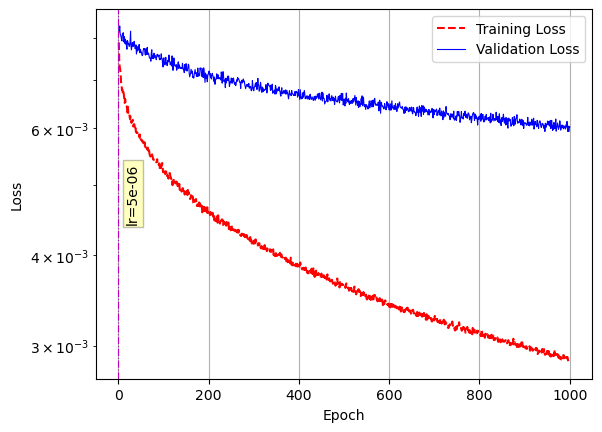



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
24/24 [==============================] - ETA: 0s - loss: 0.0099 - mse: 0.0022 - NMSE: 0.0196 - covmat_fro_loss: 0.0019 - tot_time: 0h 1m 29.5s

Epoch 1: val_NMSE improved from inf to 0.02247, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [=======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 260ms/step - loss: 0.0086 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0018 - val_loss: 0.0111 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00
Epoch 14/1000
24/24 [==============================] - ETA: 0s - loss: 0.0084 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0018 - tot_time: 0h 2m 51.4s

Epoch 14: val_NMSE did not improve from 0.02196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 253ms/step - loss: 0.0084 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0018 - val_loss: 0.0111 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00
Epoch 15/1000
24/24 [==============================] - ETA: 0s - loss:

Epoch 28/1000
24/24 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - tot_time: 0h 4m 18.8s

Epoch 28: val_NMSE did not improve from 0.02178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 259ms/step - loss: 0.0081 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - val_loss: 0.0112 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00
Epoch 29/1000
24/24 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - tot_time: 0h 4m 25.1s

Epoch 29: val_NMSE did not improve from 0.02178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 264ms/step - loss: 0.0081 - mse: 0.

24/24 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0017 - tot_time: 0h 5m 46.6s

Epoch 42: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 259ms/step - loss: 0.0079 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0017 - val_loss: 0.0111 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_covmat_fro_loss: 0.0000e+00
Epoch 43/1000
24/24 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0017 - tot_time: 0h 5m 52.9s

Epoch 43: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 265ms/step - loss: 0.0079 - mse: 0.0017 - NMSE: 0

Epoch 57/1000
24/24 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0017 - tot_time: 0h 7m 21.1s

Epoch 57: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 261ms/step - loss: 0.0076 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0017 - val_loss: 0.0111 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_covmat_fro_loss: 0.0000e+00
Epoch 58/1000
24/24 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0017 - tot_time: 0h 7m 27.4s

Epoch 58: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 262ms/step - loss: 0.0076 - mse: 0.

Epoch 72/1000
24/24 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 0.0017 - tot_time: 0h 8m 55.9s

Epoch 72: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 260ms/step - loss: 0.0073 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 0.0017 - val_loss: 0.0111 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00
Epoch 73/1000
24/24 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0017 - tot_time: 0h 9m 2.4s

Epoch 73: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 270ms/step - loss: 0.0075 - mse: 0.0

Epoch 87/1000
24/24 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0017 - tot_time: 0h 10m 30.1s

Epoch 87: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 267ms/step - loss: 0.0073 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0017 - val_loss: 0.0110 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_covmat_fro_loss: 0.0000e+00
Epoch 88/1000
24/24 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0017 - tot_time: 0h 10m 36.4s

Epoch 88: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 261ms/step - loss: 0.0073 - mse: 

24/24 [==============================] - 6s 266ms/step - loss: 0.0072 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 0.0017 - val_loss: 0.0110 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_covmat_fro_loss: 0.0000e+00
Epoch 102/1000
24/24 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - tot_time: 0h 12m 3.9s

Epoch 102: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 253ms/step - loss: 0.0071 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - val_loss: 0.0111 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00
Epoch 103/1000
24/24 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 0.0016 - tot_time: 0h 12m 10.3s

Epoch 103: val_NMSE did not improve from 0.02162
 - sav

Epoch 116/1000
24/24 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0015 - NMSE: 0.0132 - covmat_fro_loss: 0.0016 - tot_time: 0h 13m 31.5s

Epoch 116: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 253ms/step - loss: 0.0070 - mse: 0.0015 - NMSE: 0.0132 - covmat_fro_loss: 0.0016 - val_loss: 0.0111 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00
Epoch 117/1000
24/24 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0015 - NMSE: 0.0133 - covmat_fro_loss: 0.0016 - tot_time: 0h 13m 37.8s

Epoch 117: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 263ms/step - loss: 0.0071 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 264ms/step - loss: 0.0070 - mse: 0.0015 - NMSE: 0.0131 - covmat_fro_loss: 0.0016 - val_loss: 0.0112 - val_mse: 0.0025 - val_NMSE: 0.0223 - val_covmat_fro_loss: 0.0000e+00
Epoch 131/1000
24/24 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0014 - NMSE: 0.0129 - covmat_fro_loss: 0.0016 - tot_time: 0h 15m 5.1s

Epoch 131: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 260ms/step - loss: 0.0069 - mse: 0.0014 - NMSE: 0.0129 - covmat_fro_loss: 0.0016 - val_loss: 0.0112 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00
Epoch 132/1000
24/24 [==============================] - ETA: 0s - lo

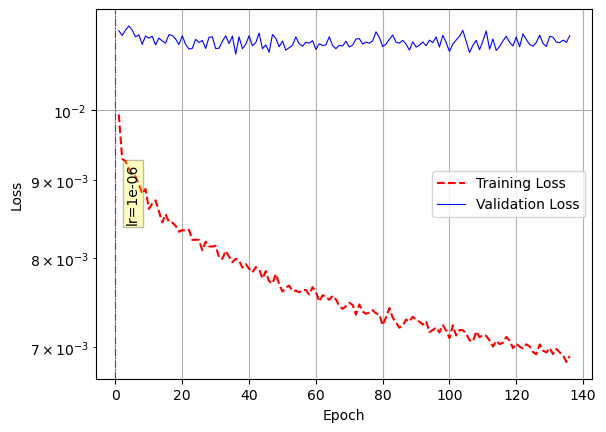

In [21]:
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_GRU,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=stateful,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)

In [22]:
### Training the combined AE-RNN
